# Justin Butler - AAE 537: HW3

This assignment was created in Jupyter Notebook and compiled using $\LaTeX$

In [1]:
%%javascript
// Making sure the outputs display correctly
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Importing required packages for this homework
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
%matplotlib inline

In [3]:
""" THIS CODE BLOCK CONTAINS ALL DEFINED FUNCTIONS FOR THIS ASSIGNMENT """
#Round to three decimals
def rounds(number):
    trunc = float('%.3f'% (number * 1000/1000))
    return(trunc)
#Convert from Bar to Atm
def BAC(bar):
    atm = bar * 0.986923
    return(rounds(atm))
#Isentropic total pressure
def totalPres(Ps,M, gamma=1.4):
    total = Ps * ((1+((gamma-1)/2)*M**2)**(gamma/(gamma-1)))
    return(rounds(total))
#Isentropic static pressure
def statPres(Pt,M,gamma=1.4):
    static = Pt / ((1+((gamma-1)/2)*M**2)**(gamma/(gamma-1)))
    return(rounds(static))
#Isentropic total temperature
def totalTemp(Ts,M,gamma=1.4):
    total = Ts * (1 + ((gamma-1)/2)*M**2)
    return(rounds(total))
#Isentropic static temperature
def statTemp(Tt,M,gamma=1.4):
    static = Tt / (1 + ((gamma-1)/2)*M**2)
    return(rounds(static))
#Isentropic total density
def totalDens(rhos,M,gamma=1.4):
    total = rhos * (1 + ((gamma-1)/2)*M**2)**(1/(gamma-1))
    return(rounds(total))
#Isentropic static density
def statDens(rhot,M,gamma=1.4):
    static = rhot / (1 + ((gamma-1)/2)*M**2)**(1/(gamma-1))
    return(rounds(static))
#Tabulate method
def buildTable(label,array,air):
    newList = [label]
    newList.append(air)
    for item in array:
        newList.append(item)
    return(newList)
#Newton's method to find mach from area ratio
def machFromPres(rat,gamma=1.4):
    mach = np.sqrt((2/(gamma-1)) * 
                  (rat**((gamma-1)/gamma) - 1))
    return(mach)
class atmosphere:
    def __init__(self, val, valGiven = 0,units = "SI"):
        #Convert from US to SI
        if units != "SI" and valGiven == 0:
            val = val / 3.281
        if units != "SI" and valGiven == 1:
            val = val * 0.04788
        #0 implies the given value is an altitude
        #1 implies the given value is a pressure
        if valGiven == 0:
            self.h = val
        elif valGiven == 1:
            self.P = val
        else:
            print("Not a valid 'valGiven' parameter.")
    def hCalc(self):
        if self.h < 11000:
            self.T = 15.04 - 0.00649*self.h
            self.P = 101.29 * ((self.T + 273.1)/228.08)**(5.256)
        elif self.h < 25000:
            self.T = -56.46
            self.P = 22.65 * np.exp(1.73 - 0.000157*self.h)
        elif self.h > 24999:
            self.T = -131.21 + 0.00299*self.h
            self.P = 2.488 * ((self.T + 273.1)/216.6)**(-11.388)
        self.rho = self.P / (0.2869 * (self.T + 273.1))
    def PCalc(self):
        if self.P > 22.632:
            self.T = (288.08*(self.P/101.29)**(1/5.256))-273.1
            self.h = (self.T - 15.04)/(-0.00649)
        elif self.P > 0.1113586:
            self.T = -56.46
            self.h = (1.73 - np.log((self.P/22.65)))/(0.000157)
        else:
            self.T = (216.6*(self.P/2.488)**(1/(-11.388)))-273.1
            self.h = (self.T + 131.21)/0.00299
        self.rho = self.P / (0.2869 * (self.T + 273.1))
def unitConv(val,valType,inType="SI"):
    if valType == "altitude" or valType=="distance" and inType=="SI":
        return(val * 3.28084)

## Problem 1

To start problem 1, we will define all of the given values:

In [4]:
## Given values from problem-statement
mixRat = 3.8 #ox/fuel
P_c = 40 #atm
mDot = 40 #kg/s
T_a = 500 #K
P_a = 1.0 #atm
M_a = 1.5

### Part i)
The first code block utilizes the CEA wrapper to generate values for the rocket flow and the air flow. The second code block determines the nozzle exit area and flow conditions required to expand the rocket exhaust to the local air pressure.

In [5]:
"""
A CEA wrapper for python requires a FORTRAN compiler,
which as of 9/25 is not installed onto the computers 
in the Aero lab. I will endeavor to install it on my 
personal computer, but for now I will include this 
section of code.
"""
##### The order of the rocket values go: #####
#####      CHAMBER - THROAT - EXIT       #####

# Static Pressures in atm
P = [BAC(40.530),BAC(23.518),BAC(1.0132)]
# Static Temperature in K
T = [3490.40, 3333.43, 1953.66]
# rho values in kg/cu m
rho = [3.1414, 1.9353, 0.14227]
# Molecular weight
mol = [22.494, 22.807, 22.807]
# C_p values in kJ/(kg * K)
C_p = [7.9264, 7.9101, 2.0456]
# ratio of specific heats
gamma = [1.1255, 1.1217, 1.2169]
# mach numbers
mach = [0.000, 1.000,  2.904]
# Total Pressures in atm
P0 = [totalPres(P[i],mach[i],gamma[i]) for i in range(len(P))]
# Total Temperature in K
T0 = [totalTemp(T[i],mach[i],gamma[i]) for i in range(len(T))]
# Stream velocity
u = [rounds(mach[i] * np.sqrt(gamma[i]*(8314/mol[i])*T[i]))
     for i in range(len(mach))]

##### Air stream values #####
T_0a = totalTemp(T_a,M_a)
P_0a = totalPres(P_a,M_a)
gamma_a = 1.4
rho_a = 0.7060 #at T approximately 500 K
u_a = rounds(M_a * np.sqrt(1.4*(8314/28.97)*T_a))
mol_a = 28.97
C_pa = 1.030

## Misc values
AeAt = 5.8754
cStar = [1793.8,1793.8]
cF = [0.6508,1.5069]
Ivac = [2208.4,2966.6]
Isp = [1167.5,2703.1]

## Tabulating values (C stands for 'chart')
CT = buildTable("Temperature (K)",T,T_a)
CT0 = buildTable("Total Temp (K)",T0,T_0a)
CP = buildTable("Pressure (atm)",P,P_a)
CP0 = buildTable("Total Pres (atm)",P0,P_0a)
Cmach = buildTable("Mach",mach,M_a)
Cu = buildTable("Sonic Vel (m/s)",u,u_a)
Crho = buildTable("Density (kg/cu m)",rho,rho_a)
Cmol = buildTable("Molar Mass (g / mol)",mol, mol_a )
Ccp = buildTable("Cp",C_p,1.030)
Cgamma = buildTable("Gamma",gamma,1.4)


table = [[" ", "Airstream", "Chamber", "Throat", "Exit" ],
         CT,CT0,CP,CP0,Cmach,Cu,Crho,Cmol,Ccp,Cgamma
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

,Airstream,Chamber,Throat,Exit
Temperature (K),500,3490.4,3333.43,1953.66
Total Temp (K),725.0,3490.4,3536.269,3740.443
Pressure (atm),1.0,40.0,23.21,1.0
Total Pres (atm),3.671,40.0,40.006,38.243
Mach,1.5,0.0,1.0,2.904
Sonic Vel (m/s),672.312,0.0,1167.495,2703.457
Density (kg/cu m),0.706,3.1414,1.9353,0.14227
Molar Mass (g / mol),28.97,22.494,22.807,22.807
Cp,1.03,7.9264,7.9101,2.0456
Gamma,1.4,1.1255,1.1217,1.2169


For the second part of ***(i)***, we want to find the area of the exit in order to properly expand the flow to the airstream pressure. To properly find the exit area, we set up the following relation:
$$A_e = (u_e)^{-1} + \dot{m}_e + (\rho_e)^{-1}$$
This relationship depends upon values gathered from CEA, and also upon our $\alpha$, which is the ratio of air flow to rocket flow. Knowing that total mass flow is $40 $ kg/s, we can find a function for rocket massflow as:
$$\dot{m}_{rocket} = \frac{40}{\alpha + 1}$$
In the following code block, we will generate graphs of exit area of the rocket as a function of $\alpha$.

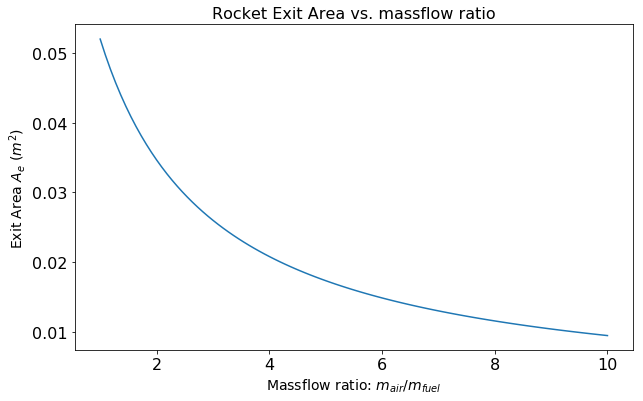

In [6]:
"""
THIS IS WRONG, BUT I HAVE TO MOVE ON
"""
def mDot_rFunc(alpha):
    mDot = 40/(alpha+1)
    return(mDot)
def A_eFunc(inp):
    output = u[-1]**(-1) * mDot_rFunc(inp) * rho[-1]**(-1)
    return(output)


alpha = np.linspace(1,10,100)
#print(u[-1])
#print(u[-1]**(-1))
A_e = [A_eFunc(item) for item in alpha]
#print(A_e)

## GRAPHING TIME! ##
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot(alpha,A_e,'-')
#
plt.title('Rocket Exit Area vs. massflow ratio', fontsize=16)
#
#plt.ylim(0,1.5)
plt.xlabel('Massflow ratio: $m_{air}$/$m_{fuel}$', fontsize=14)
plt.ylabel('Exit Area $A_e$ ($m^2$)', fontsize=14)
#plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()

### Part ii)

In [7]:
"""
Using \alpha from previous code block
"""
def mDot_aFunc(alpha):
    output = 40 / (1 + alpha**(-1))
    return(output)
def C_pmFunc(alpha):
    output = (C_pa*(mDot_aFunc(alpha)/40) 
              + C_p[-1]*(mDot_rFunc(alpha)/40))
    return(output)
def gamma_mFunc(alpha):
    output = (gamma_a*(mDot_aFunc(alpha)/40) 
              + gamma[-1]*(mDot_rFunc(alpha)/40))
    #print("gamma: " + str(output))
    return(output)
def R_mFunc(alpha):
    output = ((8314/mol_a)*(mDot_aFunc(alpha)/40) 
              + (8314/mol[-1])*(mDot_rFunc(alpha)/40))
    #print("R: " + str(output))
    return(output)
def T_tmFunc(alpha):
    output = (((mDot_aFunc(alpha) * C_pa * T_0a) + 
               (mDot_rFunc(alpha) * C_p[-1] * T0[-1])) /
              (mDot * C_pmFunc(alpha)))
    #print("T_m: " + str(output))
    return(output)
def P_tmFunc(alpha):
    output = ((1 + ((gamma_mFunc(alpha) - 1)/2) * M_mNewton(alpha))
              ** (gamma_mFunc(alpha)/(gamma_mFunc(alpha)-1)))
    return(output)
def u_mFunc(alpha):
    output = ((u[-1] + alpha * u_a)/(1 + alpha))
    #if A:
        #print("u_m: " + str(output))
    return(output)
def M_mNewton(alpha):
    A = False
    mGuess = 1
    reqRatio = 1
    ratGuess = 2
    i = 0
    while ratGuess > reqRatio:
        if i != 0:
            mGuess += 0.001
        #print(mGuess)
        ratGuess = (u_mFunc(alpha) *
                  ((gamma_mFunc(alpha) * R_mFunc(alpha) * T_tmFunc(alpha)) /
                  (1 + ((gamma_mFunc(alpha)-1)/2) * mGuess**2)
                  )**(-1./2.)) / mGuess
        #print(ratGuess)
        i += 1
        if i > 10000:
            print("Did not converge in 10,000 iterations - BREAK")
            break
    return(rounds(mGuess))
def rho_mFunc(alpha):
    output = (101325 /
              (R_mFunc(alpha) * statTemp(
              T_tmFunc(alpha), M_mNewton(alpha),gamma_mFunc(alpha)))
             )
    return(output)
def A_mFunc(alpha):
    #print(alpha)
    #print("R: ",R_mFunc(alpha))
    #print("T: ",T_tmFunc(alpha))
    #print("u: ",u_mFunc(alpha))
    #print("gam: ", gamma_mFunc(alpha))
    #print("M: ", M_mNewton(alpha))
    #print("\n")
    #output = (mDot * 
    #          ((R_mFunc(alpha)*T_tmFunc(alpha))/
    #           ((101325) * u_mFunc(alpha))) * 
    #          (1 + ((gamma_mFunc(alpha) - 1)/2)*M_mNewton(alpha)**2)**(-1))
    output = 40 / (u_mFunc(alpha) * rho_mFunc(alpha))
    return(output)
def A_aFunc(inp):
    output = u_a**(-1) * mDot_aFunc(inp) * rho_a**(-1)
    return(output)

## GRAPHING TIME! ##
def graph(x,y,xlabel=' ',ylabel=' ',title=' '):
    plt.figure(figsize=(8,6))
    plt.rc('xtick', labelsize=16) 
    plt.rc('ytick', labelsize=16)
    plt.plot(x,y,'-')
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    #plt.legend(loc=1, fontsize=16)
    plt.show()
    plt.close()

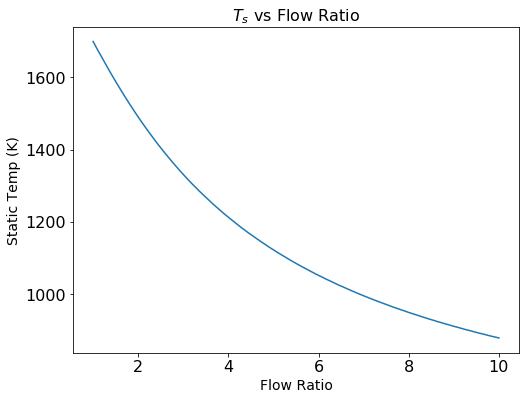

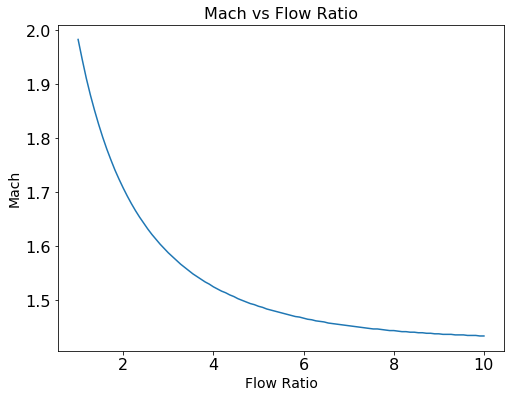

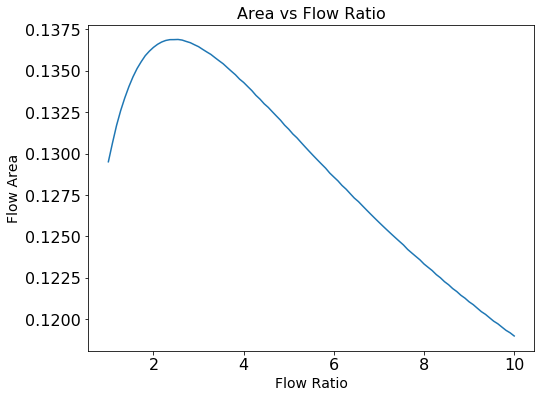

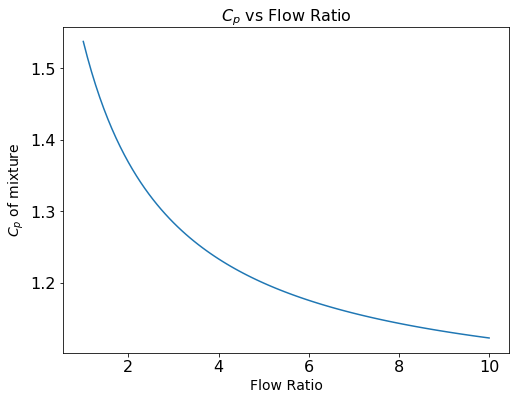

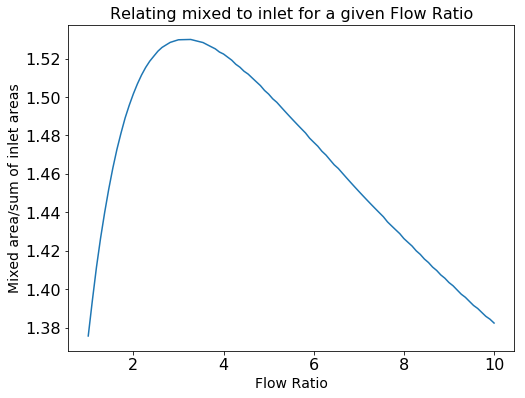

In [8]:

graph(alpha,[statTemp(T_tmFunc(item),M_mNewton(item),
                      gamma_mFunc(item)) for item in alpha],
      "Flow Ratio", "Static Temp (K)", "$T_s$ vs Flow Ratio")
graph(alpha,[M_mNewton(item) for item in alpha],
      "Flow Ratio","Mach", "Mach vs Flow Ratio")
graph(alpha,[A_mFunc(item) for item in alpha], 
     "Flow Ratio", "Flow Area", "Area vs Flow Ratio")
graph(alpha,[C_pmFunc(item) for item in alpha], "Flow Ratio",
     "$C_p$ of mixture", "$C_p$ vs Flow Ratio")
graph(alpha,
     [A_mFunc(item)/(A_aFunc(item) + A_eFunc(item)) for item in alpha],
     "Flow Ratio","Mixed area/sum of inlet areas",
      "Relating mixed to inlet for a given Flow Ratio")

## Problem 2

For number 2, we will be solving this particular problem generally. That is, let $u_1, \rho_1, \gamma_1, T_1, \mathcal{M}_1$ be the velocity, density, ratio of specific heats, static temperature, and molar mass of the upper stream. Also let $u_2, \rho_2, \gamma_2, T_2, \mathcal{M}_2$ be the velocity, density, ratio of specific heats, static temperature, and molar mass of the lower stream. Without loss of generality, we will assume that $u_2 < u_1$ and that $\rho_2 < \rho_1$.

With this assumption and these postulates, we will set several parameters for use throughout: 
\begin{align*}
r &= \frac{u_2}{u_1}\\
s &= \frac{\rho_2}{\rho_1}\\
\lambda_s &= \frac{(1-r)(1+\sqrt{s})}{2(1+r\sqrt{s})}\\
\sigma_0 &= 11
\end{align*}
With these parameters set, we will now begin our analysis. We will begin with the differential equation of depth of the mixing layer for incompressible flow - that is:
\begin{equation}
\frac{db_i}{dx} = \frac{\sqrt{\pi}}{\sigma_0}\lambda_s
\end{equation}
This incompressible flow equation can be related to the equivalent compressible flow equation as follows:
\begin{equation}
\frac{\frac{db_c}{dx}}{\frac{db_i}{dx}} = 0.2 + 0.8e^{-3M_r^2}
\end{equation}
where 
$$M_r = \frac{2(u_1 - u_2)}{1 + \sqrt{\frac{\gamma_2\mathcal{M}_1T_2}{\gamma_1\mathcal{M}_2T_1}}}$$
From this relation between copmressible and incompressible flow, we can perform the following steps to obtain a function of the mixing depth:
\begin{align*}
\frac{\frac{db_c}{dx}}{\frac{db_i}{dx}} &= 0.2 + 0.8e^{-3M_r^2}\\
\frac{db_c}{dx} &= \frac{db_i}{dx}\left(0.2 + 0.8e^{-3M_r^2}\right)\\
b(s) &= \int_0^s \frac{db_i}{dx}\left(0.2 + 0.8e^{-3M_r^2}\right) dx\\
\end{align*}
Notice, however, that all of the terms within the integral are constant values - based on postulated values we declared at the beggining of this problem. Thus, the whole of the integral can be simplified thusly:
\begin{align*}
\int_0^s \frac{db_i}{dx}\left(0.2 + 0.8e^{-3M_r^2}\right) dx &=  \frac{db_i}{dx}\left(0.2 + 0.8e^{-3M_r^2}\right)\int_0^s dx\\
&= \left(\frac{\sqrt{\pi}}{\sigma_0}\lambda_s\right)\left(0.2 + 0.8e^{-3M_r^2}\right)\cdot s
\end{align*}
Therefore, since the question asks us to find the length where the mixing layer is 1 cm, we set $b(x) = 0.1$ meter and obtain the following general equation:
\begin{equation}
s = 0.01 \cdot \left[\left(\frac{\sqrt{\pi}}{\sigma_0}\lambda_s\right)\left(0.2 + 0.8e^{-3M_r^2}\right)\right]^{-1}
\end{equation}

<div style="text-align: right"> $\blacksquare$ </div>

## Problem 3

### i)
For this part, we will assume that $\gamma = 1.4$. We will also use the NASA equations found at https://www.grc.nasa.gov/WWW/k-12/airplane/atmosmet.html to solve for atmospheric conditions. The implementation of these equations can be seen in the ***atmosphere*** class in the third code block of this paper. Furthermore, the following equations were used in the analysis to obtain the values found.

$$ P = \frac{2q}{\gamma M^2}$$
For Mil Std Inlet pressure recovery:
$$\frac{P_{t2}}{P_{t0}} = 1 - 0.075(M_0 - 1)^{1.35}$$


In [9]:
gamma = 1.4
q_c = 52.668 #kPa as converted from 1100 psf
M_in = 4
M_c = 2
P_2 = ((2*q_c)/(1.4*M_c))
P_02 = totalPres(P_2,M_c)
P_01 = rounds(P_02 * ( 1-0.075*(M_in - 1)**(1.35) )**(-1))
P_1 = statPres(P_01,M_in)
#T1 / T2
T_rat = ((1+((gamma-1)/2)*M_c**2)/(1+((gamma-1)/2)*M_in**2))
#Defining atmospheric conditions as a class
altCon = atmosphere(P_1,1)
altCon.PCalc()
alt = rounds(unitConv(altCon.h,"altitude"))
T_1 = altCon.T
T_01 = totalTemp(T_1,M_in)
T_2 = T_1 * (T_rat)**(-1)
T_02 = totalTemp(T_2,M_c)
rho_1 = altCon.rho
rho_01 = totalDens(rho_1,M_in)
## Assuming stagnation density does not change
rho_02 = rho_01
rho_2 = statDens(rho_02,M_c)

print("Altitude: ", alt,"feet")
print("Stagnation conditions:")
table = [["", "Temperature ($^\circ$C)", "Pressure (kPa)", "Density (kg/cu m)"],
         ["Inlet", T_01, P_01,rho_01],
         ["Entrance to Combustor", T_02, P_02,rho_02]
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))
print("Static conditions:")
table = [["", "Temperature ($^\circ$C)", "Pressure (kPa)", "Density (kg/cu m)"],
         ["Inlet", T_1, P_1,rounds(rho_1)],
         ["Entrance to Combustor", rounds(T_2), rounds(P_2),rho_2]
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Altitude:  79133.639 feet
Stagnation conditions:


,Temperature ($^\circ$C),Pressure (kPa),Density (kg/cu m)
Inlet,-237.132,439.667,1.684
Entrance to Combustor,-237.132,294.356,1.684


Static conditions:


,Temperature ($^\circ$C),Pressure (kPa),Density (kg/cu m)
Inlet,-56.46,2.896,0.047
Entrance to Combustor,-131.74,37.62,0.387


### ii)
In order to first find the area of the annular gap, we need to first find the velocity of the flow.
\begin{align*}
V &= M*\sqrt{\gamma R T}\\
&= 4 * \sqrt{(1.4)(287.05)(141.4)}\\
&= 953.5 m/s
\end{align*}
Thus given our desired mass flow, velocity, and density:
\begin{align*}
A &= \frac{\dot{m}}{\rho V}\\
&= \frac{5}{(0.387)(953.5)}\\
&= 0.0135 \text{ m}^2
\end{align*}
This gives a radius of 0.0656 meters, and thus the radius of the annular gap is:
$$120 - 65.6 = 54.5\text{ mm}$$

***Second half***
Assume a density of the fuel as 0.94 g/cm$^3$ as specified on page 1 of the given file. Molar masses are as follows:
- $\mathcal{M}_{air} = 28.97$ g/mol
- $\mathcal{M}_{JP-10} = 136.23$ g/mol

If $\mathcal{M}_{air} = 28.97$, and only $21\%$ of the air is $O_2$, then for one mole of $O_2$ we need $28.97 * \frac{100}{21} = 137.95$ grams of air for a single mole of air. Since 19 moles of $O_2$ are required for stoichiometric combustion, we need $137.95 * 19 = 2621.10$ grams of air to burn with one mole of the JP-10 fuel.

Thus, the Ox/Fu ratio for CEA will be:
$$\frac{2621.10}{136.23} = 19.24$$

We will also assume a frozen flow with an infinite area combustor and NFZ = 2, that is, the flow will be frozen with respect to the throat.

Since the CEA code can not run for the desired fuel temperature, or the previously calculated air temperature, those values were set to be 298.15K and 161K for the fuel and air respectively. 

From these assumptions, the following combustion conditions were obtained from CEA:

$P_c = 37.62 \text{bar}$

$T_c = 1884.29$ K

$\rho_c = 7.0063$ kg/m$^3$

$V_c = 821.7$ m/s

$A = 0.0135$ m$^2$

$\dot{m}_c = 77.7$ kg/s


### iii)


### iv)
As specified in the assignment, we will be approximating the minimum drop size by equating the aerodynamic and surface tension forces. 
$$D_{m in} = \frac{\sigma}{\rho\nu^2}$$
According to Boyd et. al., the $C_p$ of JP_10 fuel at 390 K is 69.6 cal/mol K. We will assume this value, even though the fuel is entering at 400K, since a more specific value has not been found in the literature. 

We will assume the following values. Note that these values are incorrect, but the provided literature does not give these values for the $400 K$ that we desire for the flow.

- $\sigma = 31.89$ mN$\cdot$m$^{-1}$
- $\rho = 880.32$ g$\cdot$m$^{-3}$
- $\mu = 1.029$ mPa$\cdot$s

These values then give a droplet radius at the ejector as:
\begin{align*}
D_{m in} &= \frac{31.89}{880.32\cdot (1.029/880.32)^2}\\
&= 
\end{align*}



References:

[1]Boyd, R.; Sanwal, S.; Shary-Tahrany, S.; McNally, D. The thermochemistry,
thermodynamic functions, and molecular structures of some cyclic hydrocarbons. Journal
of Physical Chemistry 75: 1264-1271; 1971. 